# Figures

In [1]:
from pathlib import Path

import colorcet as cc
import datashader as ds
import matplotlib.pyplot as plt
import napari
import numpy as np
import pandas as pd
import seaborn as sns
import tifffile
from datashader.mpl_ext import dsshow
from scipy.stats import norm, truncnorm

paper_width = 8.3
paper_margin = 1
figure_dpi = "figure"

def save_and_show(figure_file_name):
    plt.savefig(figure_file_name, dpi=figure_dpi, bbox_inches="tight")
    plt.show()

sns.set_theme(
    context="paper",
    style="ticks",
    palette="colorblind",
    color_codes=True,
)
plt.rcParams.update(
    {
        "figure.figsize": (
            paper_width - 2 * paper_margin,
            (4 / 6) * (paper_width - 2 * paper_margin),
        ),
        "figure.titlesize": 12,  # "large",
        "axes.titlesize": 10,  # 9.6,
        "axes.labelsize": 10,  # 9.6,
        "legend.fontsize": 10,  # 8.8,
        "legend.title_fontsize": 10,  # 9.6,
        "xtick.labelsize": 8,  # 8.8,
        "xtick.major.size": 7,  # 4.8,
        "xtick.minor.size": 5,  # 3.2,
        "ytick.labelsize": 8,  # 8.8,
        "ytick.major.size": 7,  # 4.8,
        "ytick.minor.size": 5,  # 3.2,
        "font.size": 10,  # 9.6,
        "font.family": 'lmodern',
        "text.usetex": True,
        "text.latex.preamble": " ".join([
            r"\usepackage{amsmath}",
            r"\usepackage{lmodern}",
        ]),
    }
)
    
sns.color_palette()

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

## Figure 1: summary

Created with BioRender

## Figure 2: 3D modeling

In [2]:
cell_data = pd.read_csv("../datasets/kuett_catena_2022/sectioning/cell_data.csv")
cell_slice_data = pd.read_csv("../datasets/kuett_catena_2022/sectioning/cell_slice_data.csv")

In [3]:
# empirically observed cell section spans

def get_empirical_cell_section_span(sectioning_axis_name):
    df = cell_slice_data[cell_slice_data["sectioning_axis_name"] == sectioning_axis_name]
    df = df.groupby(["section_thickness_um", "section_offset_um", "cell_id"]).size().reset_index(name="cell_section_span")
    df = df.groupby(["section_thickness_um", "cell_id"])["cell_section_span"].mean().reset_index(name="cell_section_span")    
    df = pd.merge(df, cell_data.loc[cell_data["sectioning_axis_name"] == "z", ["cell_id", "proj_cell_radius_um"]])
    n_short = np.floor(df["section_thickness_um"] - ((2 * df["proj_cell_radius_um"]) % df["section_thickness_um"])) + 1
    n_long = np.ceil((2 * df["proj_cell_radius_um"]) % df["section_thickness_um"]) - 1
    df["cell_section_span"] = (n_short * df["cell_section_span"] + n_long * (df["cell_section_span"] - 1)) / (n_short + n_long)
    return df

In [4]:
# model fitted to empirically observed radii

t_obs = cell_slice_data["section_thickness_um"].unique()
d_obs = 2 * cell_data.loc[cell_data["sectioning_axis_name"] == "z", "proj_cell_radius_um"].to_numpy()

mu_d = d_obs.mean()
sigma_d = d_obs.std()

n = len(d_obs)
t = t_obs
d = truncnorm.rvs(-mu_d / sigma_d, mu_d / sigma_d, loc=mu_d, scale=sigma_d, size=n, random_state=123)
s = np.ceil(d[:, np.newaxis] / t[np.newaxis, :])

mu_d, sigma_d ** 2

(7.9312735863614465, 3.1263231347964675)

In [5]:
def plot_cell_diameter(num=1000, **kwargs):
    ax = kwargs.pop("ax", plt.gca())
    sns.kdeplot(
        x=2 * cell_data.loc[cell_data["sectioning_axis_name"] == "z", "proj_cell_radius_um"],
        label=r"$d_z = 2 \sqrt{\frac{A_z}{\pi}}$",
        linestyle="-",
        color="C7",
        legend=False,
        ax=ax,
        **kwargs,
    )
    x = np.linspace(
        2 * cell_data.loc[cell_data["sectioning_axis_name"] == "z", "proj_cell_radius_um"].min(),
        2 * cell_data.loc[cell_data["sectioning_axis_name"] == "z", "proj_cell_radius_um"].max(),
        num,
    )
    y = norm.pdf(x, loc=mu_d, scale=sigma_d)
    ax.plot(x, y, label=r"$D \sim \mathcal{N}(\mu_d, \sigma_d^2)$", linestyle=":", color="C7")
    # ax.text(
    #     0.95,
    #     0.5,
    #     f"""$\\hat{{\\mu}}_r = {mu_d:.3f}$
    #         $\\hat{{\\sigma}}_r = {sigma_d:.3f}$""",
    #     transform=ax.transAxes,
    #     ha="right",
    #     va="center",
    # )
    ax.set_title(r"Cell diameter (circular approximation)")
    ax.set_xlabel(r"Diameter [$\mu m$]")
    ax.set_ylabel(r"Density")
    ax.legend(loc="upper right")

In [ ]:
mask = tifffile.imread("../datasets/kuett_catena_2022/sectioning/mask.tiff")
mask = np.pad(mask, ((20, 20), (40, 40), (40, 40)))
mask[mask.shape[0] // 2, :, :] = np.amax(mask) + 1
mask[:, mask.shape[1] // 2, :] = mask[:, :, mask.shape[2] // 2] = np.amax(mask) + 6

viewer = napari.view_labels(mask, scale=(2, 1, 1), ndisplay=3)
viewer.camera.angles=(-20, 40, -30)
mask_screenshot = viewer.screenshot()
viewer.close()

def plot_mask_screenshot(ax=None):
    if ax is None:
        ax = plt.gca()
    ax.imshow(np.where(mask_screenshot != 0, mask_screenshot, 255))
    ax.axis("off")

In [16]:
def plot_cell_section_span(**kwargs):
    ax = kwargs.pop("ax", plt.gca())
    data = pd.concat(
        {
            ("Sx", "sectioning"): get_empirical_cell_section_span("x"),            
            ("Sy", "sectioning"): get_empirical_cell_section_span("y"),            
            ("Sz", "sectioning"): get_empirical_cell_section_span("z"),
            ("S", "model"): pd.DataFrame(data=s, columns=t).melt(var_name="section_thickness_um", value_name="cell_section_span"),
        },
        names=["hue", "style", ""],
    ).reset_index()
    data["section_thickness_um"] = data["section_thickness_um"].astype("category")
    g = sns.lineplot(
        data=data,
        x="section_thickness_um",
        y="cell_section_span",
        hue="hue",
        style="style",
        hue_order=["Sx", "Sy", "Sz", "S"],
        dashes={"sectioning": "", "model": (1, 1)},
        palette=["C0", "C1", "C2", "C7"],
        marker="o",
        ci=None,
        legend=False,
        ax=ax,
        **kwargs,
    )
    ax.set_title(r"Cell section span")
    ax.set_xlabel(r"Section thickness [$\mu m$]")
    ax.set_ylabel(r"Number of sections (mean)")
    ax.legend(
        labels=[
            r"adjusted $s_x$",
            r"adjusted $s_y$",
            r"adjusted $s_z$",
            r"$S = \lceil Dt^{-1} \rceil$",
        ],
        loc="upper right",
    )

In [17]:
def plot_cell_miss_probab(**kwargs):
    ax = kwargs.pop("ax", plt.gca())
    data = pd.DataFrame(data=1 / s, columns=t).melt(
        var_name="section_thickness_um", value_name="cell_miss_probab"
    )
    data["section_thickness_um"] = data["section_thickness_um"].astype("category")
    sns.kdeplot(
        data=data,
        x="cell_miss_probab",
        hue="section_thickness_um",
        bw_method=1,
        ax=ax,
        **kwargs,
    )
    sns.rugplot(
        data=data.drop_duplicates(),
        x="cell_miss_probab",
        hue="section_thickness_um",
        height=0.05,
        ax=ax,
    )
    sns.move_legend(ax, "upper right", title="Section thickness [$\\mu m$]", ncol=2)
    ax.set_title(r"Cell miss probability (bw=$1.0$)")
    ax.set_xlabel(r"$P($cell absent in next section$) = S^{-1}$")
    ax.set_ylabel(r"Density")
    ax.set_xlim(0, 1)

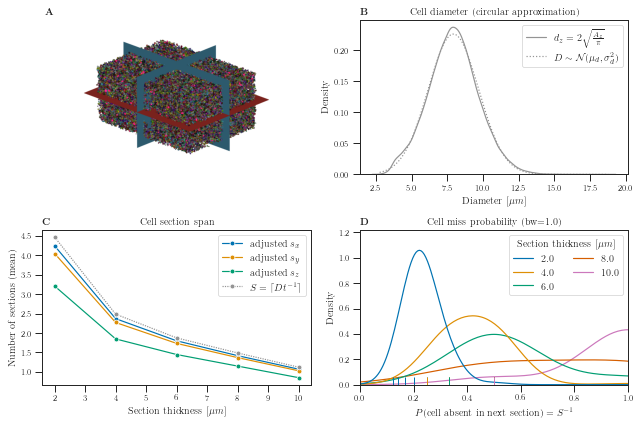

In [36]:
fig, axes = plt.subplot_mosaic(
    """AB
       CD""",
    figsize=(1.5 * plt.rcParams["figure.figsize"][0], 1.5 * plt.rcParams["figure.figsize"][1]),
)
plot_mask_screenshot(ax=axes["A"])
plot_cell_diameter(ax=axes["B"])
plot_cell_section_span(ax=axes["C"])
plot_cell_miss_probab(ax=axes["D"])
plt.tight_layout()
for label, ax in axes.items():
    ax.set_title(f"\\textbf{{{label}}}", loc="left")
save_and_show("Figure2.pdf")

## Figure 3: parameter sensitivity analysis

In [19]:
def plot_metric_distribution_by_assignment_strategy(data, metric_name, title, ylabel, **kwargs):
    ax = kwargs.pop("ax", plt.gca())
    sns.violinplot(
        x="assignment_name",
        y="metric_value",
        data=data[data["metric_name"] == metric_name],
        order=[
            "linear_sum",
            "max_intersect",
            "max_union",
            "max_union_thresQ05",
            "max_union_thresQ15",
            "max_union_thresQ25",
        ],
        inner="quartile",
        ax=ax,
        **kwargs,
    )
    ax.set_title(title)
    ax.set_xlabel("Assignment strategy")
    ax.set_ylabel(ylabel)
    ax.set_xticklabels(
        [
            "linear sum",
            "max-intersection",
            "max-union ($q=0$)",
            "max-union ($q=0.05$)",
            "max-union ($q=0.15$)",
            "max-union ($q=0.25$)",
        ],
        rotation=20,
        ha="right",
    )
    ax.set_ylim(-0.15, 1.15)

In [20]:
def plot_f1score_distribution_by_parameter_value(data, parameter_column, title, xlabel, **kwargs):
    ax = kwargs.pop("ax", plt.gca())
    sns.violinplot(
        x=parameter_column,
        y="metric_value",
        data=data[data["metric_name"] == "f1score"],
        ax=ax,
        **kwargs,
    )
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(r"$F_1$-score")
    ax.set_ylim(-0.15, 1.15)

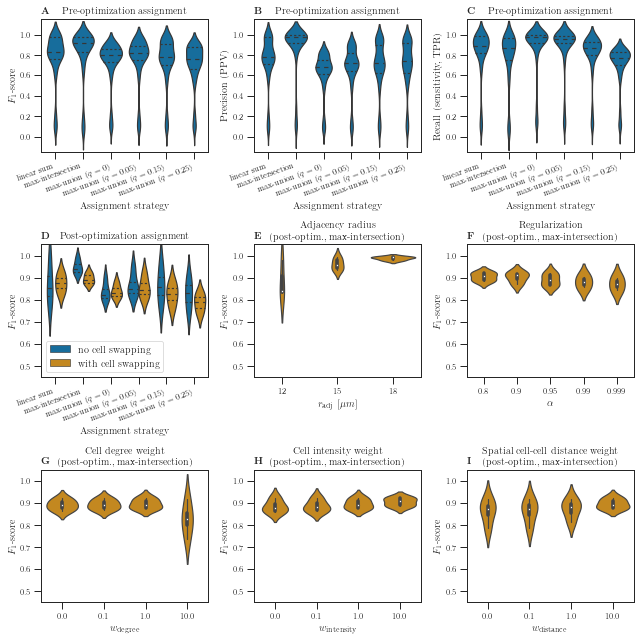

In [21]:
psa_noswap_results = pd.read_csv("../benchmarks/psa_noswap/results/results.csv")
psa_noswap_results = psa_noswap_results[psa_noswap_results["spellmatch_alpha"] != 1]
psa_swap_weights_results = pd.read_csv("../benchmarks/psa_swap_weights/results/results.csv")
psa_swap_adj_results = pd.read_csv("../benchmarks/psa_swap_adj/results/results.csv")
psa_swap_alpha_results = pd.read_csv("../benchmarks/psa_swap_alpha/results/results.csv")

fig, axes = plt.subplot_mosaic(
    """ABC
       DEF
       GHI""",
    figsize=(1.5 * plt.rcParams["figure.figsize"][0], 1.5 * plt.rcParams["figure.figsize"][0]),
)

plot_metric_distribution_by_assignment_strategy(
    psa_noswap_results,
    "f1score",
    "Pre-optimization assignment",
    "$F_1$-score",
    ax=axes["A"],
    color="C0",
)
plot_metric_distribution_by_assignment_strategy(
    psa_noswap_results,
    "precision",
    "Pre-optimization assignment",
    "Precision (PPV)",
    ax=axes["B"],
    color="C0",
)
plot_metric_distribution_by_assignment_strategy(
    psa_noswap_results,
    "recall",
    "Pre-optimization assignment",
    "Recall (sensitivity, TPR)",
    ax=axes["C"],
    color="C0",
)

data = pd.concat(
    {
        "no cell swapping": psa_noswap_results[
            (psa_noswap_results["spellmatch_alpha"] == 0.8)
            & (psa_noswap_results["spellmatch_degree_weight"] == 1)
            & (psa_noswap_results["spellmatch_intensity_weight"] == 1)
            & (psa_noswap_results["spellmatch_distance_weight"] == 10)
        ],
        "with cell swapping": psa_swap_weights_results[
            (psa_swap_weights_results["spellmatch_degree_weight"] == 1)
            & (psa_swap_weights_results["spellmatch_intensity_weight"] == 1)
            & (psa_swap_weights_results["spellmatch_distance_weight"] == 10)
        ],
    },
    names=["Benchmark", None],
).reset_index(level=0)
plot_metric_distribution_by_assignment_strategy(
    data,
    "f1score",
    "Post-optimization assignment",
    "$F_1$-score",
    hue="Benchmark",
    palette=["C0", "C1"],
    ax=axes["D"],
)
axes["D"].legend_.set_title(None)
axes["D"].set_ylim(0.45, 1.05)
    
plot_f1score_distribution_by_parameter_value(
    psa_swap_adj_results[psa_swap_adj_results["assignment_name"] == "max_intersect"],
    "spellmatch_adj_radius",
    "Adjacency radius\n(post-optim., max-intersection)",
    r"$r_\mathrm{adj}$ [$\mu m$]",
    ax=axes["E"],
    color="C1",
)
axes["E"].set_ylim(0.45, 1.05)

plot_f1score_distribution_by_parameter_value(
    psa_swap_alpha_results[psa_swap_alpha_results["assignment_name"] == "max_intersect"],
    "spellmatch_alpha",
    "Regularization\n(post-optim., max-intersection)",
    r"$\alpha$",
    ax=axes["F"],
    color="C1",
)
axes["F"].set_ylim(0.45, 1.05)

psa_swap_weights_results = pd.read_csv("../benchmarks/psa_swap_weights/results/results.csv")
plot_f1score_distribution_by_parameter_value(
    psa_swap_weights_results[
        (psa_swap_weights_results["assignment_name"] == "max_intersect")
        # & (psa_swap_weights_results["spellmatch_degree_weight"] == 1)
        & (psa_swap_weights_results["spellmatch_intensity_weight"] == 1)
        & (psa_swap_weights_results["spellmatch_distance_weight"] == 10)
    ],
    "spellmatch_degree_weight",
    "Cell degree weight\n(post-optim., max-intersection)",
    r"$w_\mathrm{degree}$",
    ax=axes["G"],
    color="C1",
)
axes["G"].set_ylim(0.45, 1.05)
plot_f1score_distribution_by_parameter_value(
    psa_swap_weights_results[
        (psa_swap_weights_results["assignment_name"] == "max_intersect")
        & (psa_swap_weights_results["spellmatch_degree_weight"] == 1)
        # & (psa_swap_weights_results["spellmatch_intensity_weight"] == 1)
        & (psa_swap_weights_results["spellmatch_distance_weight"] == 10)
    ],
    "spellmatch_intensity_weight",
    "Cell intensity weight\n(post-optim., max-intersection)",
    r"$w_\mathrm{intensity}$",
    ax=axes["H"],
    color="C1",
)
axes["H"].set_ylim(0.45, 1.05)
plot_f1score_distribution_by_parameter_value(
    psa_swap_weights_results[
        (psa_swap_weights_results["assignment_name"] == "max_intersect")
        & (psa_swap_weights_results["spellmatch_degree_weight"] == 1)
        & (psa_swap_weights_results["spellmatch_intensity_weight"] == 1)
        # & (psa_swap_weights_results["spellmatch_distance_weight"] == 10)
    ],
    "spellmatch_distance_weight",
    "Spatial cell-cell distance weight\n(post-optim., max-intersection)",
    r"$w_\mathrm{distance}$",
    ax=axes["I"],
    color="C1",
)
axes["I"].set_ylim(0.45, 1.05)

plt.tight_layout()
for label, ax in axes.items():
    ax.set_title(f"\\textbf{{{label}}}", loc="left")
save_and_show("Figure3.pdf")

## Figure 4: algorithm benchmark

In [ ]:
# benchmark_results = pd.read_csv("../benchmarks/benchmark2/results/results.csv")
# benchmark_results = benchmark_results[benchmark_results["algorithm_converged"] != False]

# sns.catplot(
#     data=benchmark_results[
#         (benchmark_results["assignment_name"] == "max_intersect")
#         & (benchmark_results["metric_name"] == "f1score")
#     ],
#     x="algorithm_config_name",
#     y="metric_value",
#     row="simutome_image_rotation",
#     col="simutome_image_translation",
#     # 
# )
# plt.tight_layout()
# plt.show()

# f1score/precision/recall
# uncertainty measures
# mis-alignment (rotation, translation)
# algorithm

## Figure 5: application example

Created with spellmatch

# Supplementary Figures

## Figure S1: single-cell statistics for 3D modeling

In [23]:
cell_data = pd.read_csv("../datasets/kuett_catena_2022/sectioning/cell_data.csv")

In [24]:
def plot_cell_volume_distribution(**kwargs):
    ax = kwargs.pop("ax", plt.gca())
    sns.kdeplot(
        x=cell_data.groupby("cell_id")["cell_volume_um3"].mean(),
        color="C0",
        ax=ax,
        **kwargs,
    )
    ax.set_title("Cell volume")
    ax.set_xlabel(r"Volume [$\mu m^3$]")
    ax.legend([r"$V$"])

In [25]:
def plot_cell_area_distributions(**kwargs):
    ax = kwargs.pop("ax", plt.gca())
    sns.kdeplot(
        data=cell_data,
        x="proj_cell_area_um2",
        hue="sectioning_axis_name",
        hue_order=["z", "y", "x"],
        palette=["C1", "C2", "C3"],
        ax=ax,
        **kwargs,
    )
    ax.set_title("Cell area\n(maximum projection after re-sectioning)")
    ax.set_xlabel(r"Area [$\mu m^2$]")
    ax.legend_.set_title(None)
    for text, label in zip(ax.legend_.texts, [ r"$A_z$", r"$A_y$", r"$A_x$"]):
        text.set_text(label)

In [31]:
def plot_cell_radius_distributions(**kwargs):
    ax = kwargs.pop("ax", plt.gca())
    sns.kdeplot(
        data=cell_data[cell_data["sectioning_axis_name"] == "z"],
        x="cell_radius_um",
        color="C0",
        legend=False,
        ax=ax,
        **kwargs,
    )
    sns.kdeplot(
        data=cell_data,
        x="proj_cell_radius_um",
        hue="sectioning_axis_name",
        hue_order=["z", "y", "x"],
        palette=["C1", "C2", "C3"],
        legend=False,
        ax=ax,
        **kwargs,
    )
    ax.set_title("Cell radius\n(circular/spherical approximations)")
    ax.set_xlabel(r"Radius [$\mu m$]")
    ax.legend(
        handles=ax.lines[:3][::-1] + ax.lines[3:],
        labels=[
            r"$r_z = \sqrt{\frac{A_x}{\pi}}$",
            r"$r_y = \sqrt{\frac{A_y}{\pi}}$",
            r"$r_x = \sqrt{\frac{A_z}{\pi}}$",
            r"$r = \sqrt[3]{\frac{3 V}{4 \pi}}$",
        ],
    )

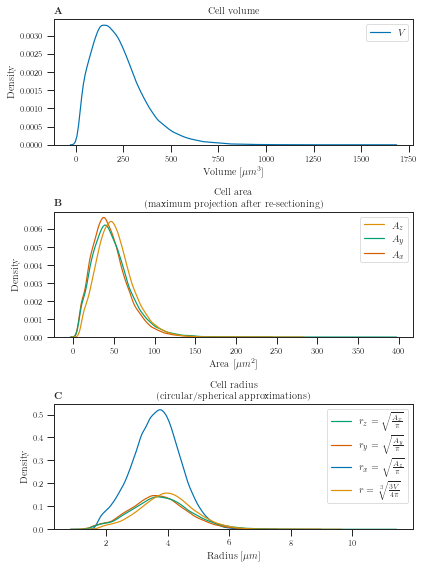

In [34]:
fig, axes = plt.subplot_mosaic(
    """A
       B
       C""",
    figsize=(plt.rcParams["figure.figsize"][0], 2 * plt.rcParams["figure.figsize"][1]),
)

plot_cell_volume_distribution(ax=axes["A"])
plot_cell_area_distributions(ax=axes["B"])
plot_cell_radius_distributions(ax=axes["C"])

plt.tight_layout()
for label, ax in axes.items():
    ax.set_title(f"\\textbf{{{label}}}", loc="left")
save_and_show("FigureS1.pdf")

## Figure S2: cell centroid displacement (synthetic sectioning)

In [28]:
cell_slice_displacement_data = pd.read_csv("../datasets/kuett_catena_2022/sectioning/cell_slice_displacement_data.csv")

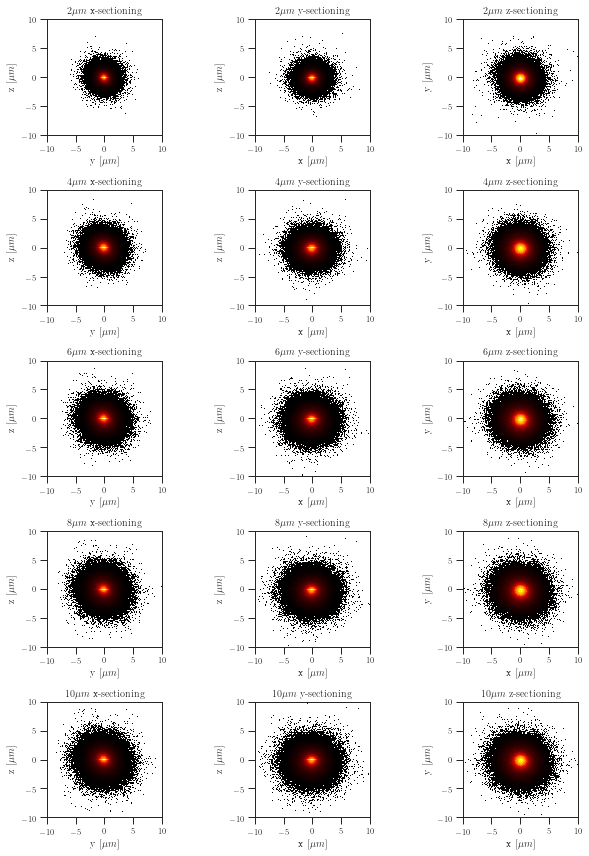

In [35]:
sectioning_axis_names = ("x", "y", "z")
fig, axes = plt.subplots(
    nrows=cell_slice_displacement_data["section_thickness_um"].nunique(),
    ncols=3,
    figsize=(1.5 * plt.rcParams["figure.figsize"][0], 3 * plt.rcParams["figure.figsize"][1]),
)
for row_axes, (section_thickness_um, g) in zip(axes, cell_slice_displacement_data.groupby("section_thickness_um")):
    for ax, sectioning_axis_name in zip(row_axes, sectioning_axis_names):
        x, y = tuple(a for a in sectioning_axis_names if a != sectioning_axis_name)
        dsshow(
            g[g["sectioning_axis_name"] == sectioning_axis_name],
            ds.Point(f"cell_slice_centroid_displacement_{x}_um", f"cell_slice_centroid_displacement_{y}_um"),
            cmap=cc.fire,
            ax=ax,
        )
        ax.set_title(f"${section_thickness_um:g} \\mu m$ {sectioning_axis_name}-sectioning")
        ax.set_xlabel(f"{x} [$\\mu m$]")
        ax.set_ylabel(f"{y} [$\\mu m$]")
        ax.set_ylim(-10, 10)
        ax.set_xlim(-10, 10)

plt.tight_layout()
save_and_show("FigureS2.pdf")

## Figure S3: image selection for semi-synthetic data generation

In [30]:
# 4 images

## Figure S4: post-optimization uncertainty & assignment